In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import haversine as hs
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
competitor_df2 = pd.read_csv("competitor_info10.csv")

# Data Preprocessing

After scrapping the data from the google maps, the number value had to be converted to float so that it can be applied for classifiers later.

In [5]:
# Converting all string data to numerical
def convert_float(x):
    if x == "nan":
        return 0
    if "K" in str(x):
        return 0
    else:
        return float(x)

In [7]:
competitor_df2["reviews_count"] = competitor_df2["reviews_count"].apply(lambda x: convert_float(x)) 

In [8]:
competitor_df2["rating"] = competitor_df2["rating"].apply(lambda x: convert_float(x))

In [10]:
dist = competitor_df2["lat_long"].tolist()
dist_lst = []
for x in dist:
    y = x.replace('(','').replace(')','')  
    res = tuple(map(float, y.split(',')))
    dist_lst.append(res)

Labeling each dental clinics based on review count and ratings.

Label 1 if review count is more than 10 and rating is more than 3.7

In [12]:
competitor_df2["Label"] = np.nan
for i in range(len(competitor_df2)):
    if competitor_df2["reviews_count"].iloc[i] > 10 and competitor_df2["rating"].iloc[i] > 3.7:
        competitor_df2["Label"].iloc[i] = 1
    else:
        competitor_df2["Label"].iloc[i] = 0

Getting median income data based on census tract

From this website
https://data.census.gov/table?q=median&t=Income+(Households,+Families,+Individuals)&g=0100000US$310000_1400000US25017368300&y=2010&d=ACS+5-Year+Estimates+Detailed+Tables&tid=ACSDT5Y2010.B19113

In [14]:
competitor_df2["Census_Tract"].unique()
income_df = pd.read_csv("Median_income.csv")
diction = {}
for (colname,colval) in income_df.iteritems():
    if "Estimate" in colname:
        key = float(colname.split(",")[0].split(" ")[2])
        value = float(colval.values[0].replace(",", ""))
        diction[key] = value

income_lst = []

for k in competitor_df2["Census_Tract"]:
    if k in diction.keys():
        income_lst.append(diction[k])
    else:
        income_lst.append(0)

competitor_df2["Median_Income"] = income_lst

In [15]:
income2 = [75192,96786,96786,75192,101735, 75192, 96786, 75192, 101735, 96786,96786, 101735, 75192, 101735, 69333]
len(income2)
len(competitor_df2.loc[competitor_df2["Median_Income"] == 0])

15

In [16]:
competitor_df2["Median_Income"].loc[competitor_df2["Median_Income"] == 0] = income2

In [17]:
competitor_df2.to_csv("competitor_info10.csv", index = False)

In [18]:
center_df = pd.read_csv("center_data.csv")

In [19]:
income_lst = []
for k in center_df["census_tract"]:
    if k in diction.keys():
        income_lst.append(diction[k])
    else:
        income_lst.append("Na")

In [ ]:
center_df["Median_Income"] = income_lst

,Address,census_tract,Population,Lat_Long,avg_distance
0,"441 Lincoln Street, Waltham, MA 02451",3681.02,4718,"(42.402936, -71.24819)",8.817687
1,"320 Prospect Hill Road, Waltham, MA 02451",3682.00,4198,"(42.384458, -71.252627)",8.023349
2,"23 Wellington Street, Waltham, MA 02451",3683.00,5763,"(42.377161, -71.248068)",7.618208
3,"324 Bishops Forest Drive, Waltham, MA 02452",3689.02,3691,"(42.379787, -71.230603)",7.374341
4,"College Drive, Waltham, MA 02452",3690.00,3300,"(42.386681, -71.221165)",7.643915
5,"271 Waverley Oaks Road, Waltham, MA 02452",3691.00,5059,"(42.383564, -71.206967)",7.798963


In [ ]:
center_df.to_csv("center_data2.csv", index = False)

Make dataframe based on population centers in Waltham district and save as center_df to apply ML classifiers later.

In [ ]:
# Get the location data for center of population in Waltham area

center_add = ["441 Lincoln Street, Waltham, MA 02451", "320 Prospect Hill Road, Waltham, MA 02451", "23 Wellington Street, Waltham, MA 02451", "324 Bishops Forest Drive, Waltham, MA 02452", "College Drive, Waltham, MA 02452","271 Waverley Oaks Road, Waltham, MA 02452" ]
center_tract = [3681.02,3682.00,3683.00,3689.02,3690.00,3691.00]
center_pop = [4718,4198,5763,3691,3300,5059]
center_lat_long = [(42.402936,-71.248190),(42.384458,-71.252627),(42.377161,-71.248068),(42.379787,-71.230603), (42.386681,-71.221165), (42.383564,-71.206967)]


d = {"Address":center_add, "census_tract":center_tract, "Population": center_pop, "Lat_Long": center_lat_long, "avg_distance": center_avg_dist}
center_df = pd.DataFrame(data = d, index = ["A", "B", "C", "D", "E", "F"])


# Data Exploration

Made boxplot to identify outliers using average distance. If average distance had a huge difference with other avgerage distances it was considered as outliers and removed from the dataset.

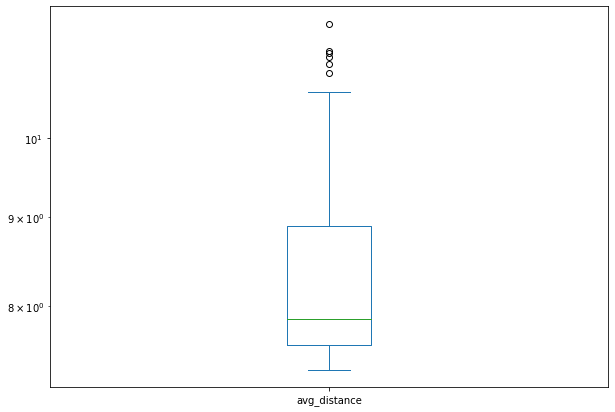

In [22]:
# Identify outliers by using avg distance
# Make a boxplot to find outliers
fig = plt.figure(figsize =(10, 7))
data = competitor_df2["avg_distance"]
competitor_df2['avg_distance'].plot(kind='box')
# switch the Y-axis to a logarithmic scale by adding in plt.semilogy()
plt.semilogy();
plt.show()

# Find the upper bound for outliers
q3, q1 = np.percentile(data, [75, 25])
IQR = q3 - q1
upper_bound = q3 + 1.5*IQR
upper_bound

# Remove outliers to get better accuracy for models
competitor_df2 = competitor_df2.loc[competitor_df2["avg_distance"] < upper_bound]

Used three main variable median income, population and avg distance to predict the labels for dental clinics which had the highest correlation with the label.

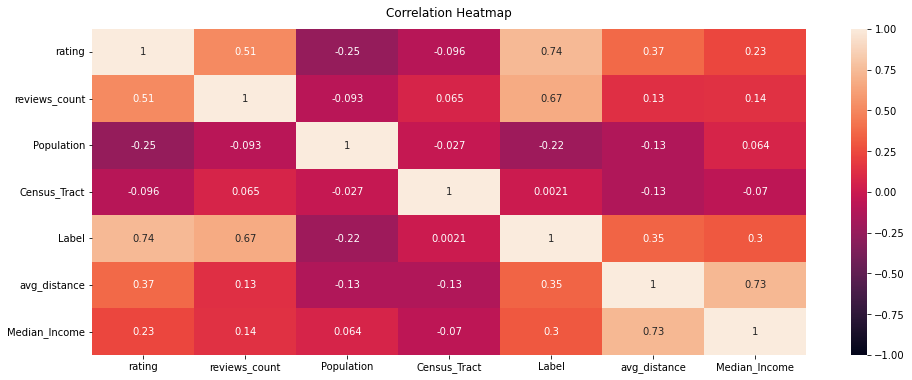

In [23]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(competitor_df2.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig("Correlation.png");

Visualized average of variable population, median income, average distance, ratings to see how these variable differs between label 1 and label 0 data

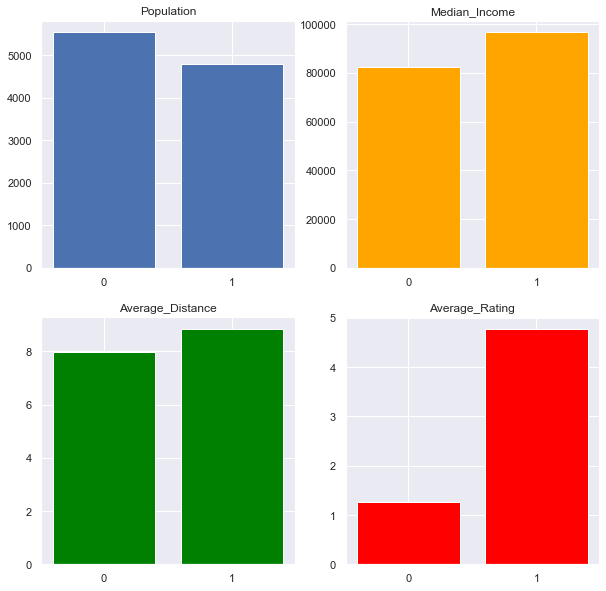

In [356]:
%matplotlib inline
barWidth = 0.1
plt.rcParams["figure.figsize"] = (10,10)
x = ["0","1"]
label_group = competitor_df2.groupby("Label").agg("mean")
fig, axs = plt.subplots(2, 2)
axs
axs[0, 0].bar(x, label_group["Population"])
axs[0, 0].set_title('Population')

axs[0,1].bar(x, label_group["Median_Income"], color = "orange")
axs[0,1].set_title("Median_Income")

axs[1,0].bar(x, label_group["avg_distance"], color = "green")
axs[1,0].set_title("Average_Distance")

axs[1,0].bar(x, label_group["avg_distance"], color = "green")
axs[1,0].set_title("Average_Distance")

axs[1,1].bar(x, label_group["rating"], color = "red")
axs[1,1].set_title("Average_Rating")


plt.savefig("Mean_group.png");

Plotted label 1 and label 0 data based on average distance and median income.
It shows that label 1 data is more clustered around higher average distance and median income than label 0 data.

In [12]:
pos = competitor_df2.loc[competitor_df2["Label"] == 1][["Population", "avg_distance", "Median_Income"]]
neg = competitor_df2.loc[competitor_df2["Label"] == 0][["Population", "avg_distance", "Median_Income"]]

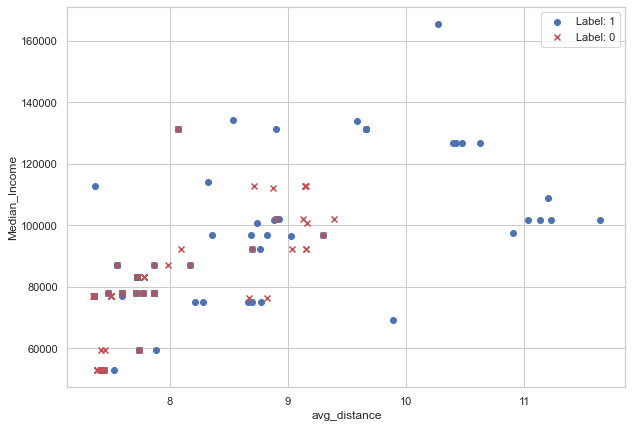

In [202]:
# find positive and negative cases
# plot the data
plt.rcParams["figure.figsize"] = (10,7)
plt.scatter(pos["avg_distance"],pos["Median_Income"], marker='o', c='b')
plt.scatter(neg["avg_distance"],neg["Median_Income"], marker='x', c='r')
plt.xlabel('avg_distance')
plt.ylabel('Median_Income')
plt.legend(["Label: 1", 'Label: 0'])
plt.savefig("pos&neg.png");

# Applying ML Classifiers

Applied logistic regression to predict the labels.

In [34]:
# Implement logistic regression classifier
X = competitor_df2[["avg_distance", "Median_Income", "Population"]].values
y = competitor_df2["Label"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=24)
logreg = LogisticRegression(solver='lbfgs', random_state=24)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy for logistic regression:",round(accuracy_score(y_test, y_pred),2))

Accuracy for logistic regression: 0.81


Plotted roc auc curve to see how logistic regression classifier is working

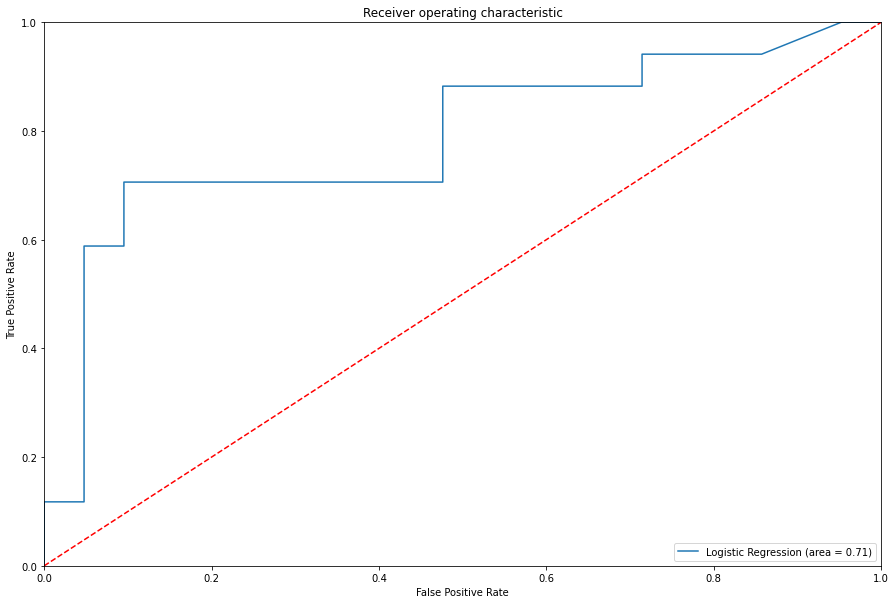

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_curve(y_test, y_pred)
# Getting prob for positive label
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (15,10))
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc[1][1])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC', facecolor = "white", transparent = False)
plt.show()

Applied Naive Bayseian Classifier to predict labels.

In [7]:
# Applying Naive Bayseian classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
# split train and test data
X = competitor_df2[["Population", "avg_distance", "Median_Income"]].values
y = competitor_df2["Label"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=24)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(round(accuracy_score(y_test, y_pred),2))

0.74


Accuracy for SVM linear kernel: 0.68


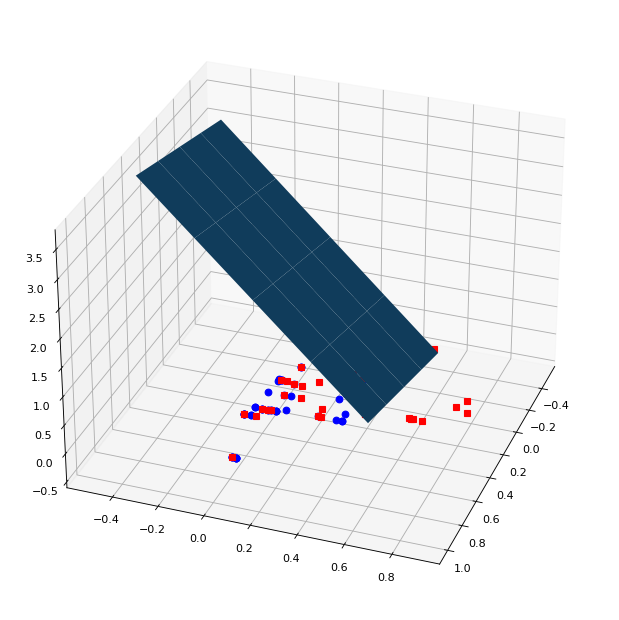

In [5]:
# Applying Support Vector Machine
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

X = competitor_df2[["Population", "avg_distance", "Median_Income"]].values
Y = competitor_df2["Label"]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X_train,X_test, y_train, y_test = train_test_split(scaled_X,Y, test_size = 0.3, random_state=27)
model = svm.SVC(kernel="linear")
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy for SVM linear kernel:", round(accuracy_score(y_test, y_pred),2))
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
tmp = np.linspace(-0.5,0.5,5)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(X_train[y_train==0,0], X_train[y_train==0,1], X_train[y_train==0,2],'ob')
ax.plot3D(X_train[y_train==1,0], X_train[y_train==1,1], X_train[y_train==1,2],'sr')
ax.plot_surface(x, y, z(x,y))
ax.view_init(30, 20)
plt.savefig('SVM.png')
plt.show()


In [6]:
X = competitor_df2[["Population", "avg_distance", "Median_Income"]].values
Y = competitor_df2["Label"]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X_train,X_test, y_train, y_test = train_test_split(scaled_X,Y, test_size = 0.3, random_state=30)
model = svm.SVC(kernel="poly", degree = 2)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy for SVM Quadratic kernel:", round(accuracy_score(y_test, y_pred),2))


Accuracy for SVM Quadratic kernel: 0.66


In [40]:
X = competitor_df2[["Population", "avg_distance", "Median_Income"]].values
Y = competitor_df2["Label"]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X_train,X_test, y_train, y_test = train_test_split(scaled_X,Y, test_size = 0.3, random_state=30)
model = svm.SVC(kernel="rbf")
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy for SVM Quadratic kernel:", round(accuracy_score(y_test, y_pred),2))

Accuracy for SVM Quadratic kernel: 0.64


# Predict labels for test data

Apply logistic regression and predict labels

In [41]:
center_df = pd.read_csv("center_data3.csv")
center_df

,Address,census_tract,Population,Lat_Long,avg_distance,Median_Income
0,"441 Lincoln Street, Waltham, MA 02451",3681.02,4718,"(42.402936, -71.24819)",8.817687,102083.0
1,"320 Prospect Hill Road, Waltham, MA 02451",3682.00,4198,"(42.384458, -71.252627)",8.023349,112778.0
2,"23 Wellington Street, Waltham, MA 02451",3683.00,5763,"(42.377161, -71.248068)",7.618208,78088.0
3,"324 Bishops Forest Drive, Waltham, MA 02452",3689.02,3691,"(42.379787, -71.230603)",7.374341,59375.0
4,"College Drive, Waltham, MA 02452",3690.00,3300,"(42.386681, -71.221165)",7.643915,87109.0
5,"271 Waverley Oaks Road, Waltham, MA 02452",3691.00,5059,"(42.383564, -71.206967)",7.798963,87109.0


In [42]:
X = center_df[["avg_distance", "Median_Income", "Population"]].values
logreg.predict(X)

array([1., 1., 0., 0., 1., 0.])